In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno_interp import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(alpha_aux=[Normal(0,2), Normal(0,2)], float_b=True, b_aux=Normal(1000,100)),
               LossTracker(),SaveBest('weights/best_ii4.h5'),EarlyStopping(10)])

1: Train=1034.3662768554686 Valid=626.364130859375
2: Train=555.3117514038086 Valid=542.7838671875
3: Train=501.04503143310546 Valid=503.4636932373047
4: Train=471.97407470703126 Valid=483.1137585449219
5: Train=452.0818786621094 Valid=468.2309936523437
6: Train=439.92389739990233 Valid=461.2820684814453
7: Train=428.51056915283203 Valid=448.02103149414063
8: Train=417.4069985961914 Valid=443.7793212890625
9: Train=415.95732971191404 Valid=436.5467224121094
10: Train=409.496728515625 Valid=432.68809387207034
11: Train=401.4872769165039 Valid=425.7206524658203
12: Train=399.94242767333986 Valid=424.4623040771484
13: Train=393.31583404541016 Valid=418.68630126953127
14: Train=391.21140380859373 Valid=423.3652331542969
15: Train=393.2781106567383 Valid=414.59519348144534
16: Train=384.65448303222655 Valid=408.4774951171875
17: Train=381.8560095214844 Valid=409.81107421875
18: Train=381.60768432617186 Valid=416.3718835449219
19: Train=382.6847570800781 Valid=409.5478564453125
20: Train=381

In [8]:
model.save('weights/Inferno_Test_interp_bm4.h5')

In [9]:
model.load('weights/Inferno_Test_interp_bm4.h5')

# Results

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0,1.0
1,4,1.0
2,1,1.0
3,4,1.0
4,4,1.0


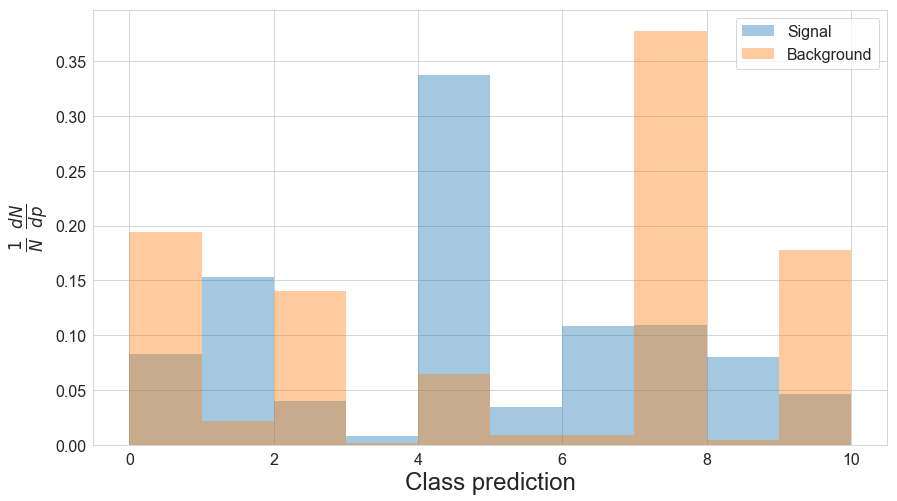

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,0,1.0,0
1,4,1.0,4
2,1,1.0,1
3,4,1.0,4
4,4,1.0,4


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([0.0828, 0.1533, 0.0396, 0.0081, 0.3376, 0.0344, 0.1085, 0.1089, 0.0802,
         0.0465]),
 tensor([0.1941, 0.0218, 0.1405, 0.0015, 0.0645, 0.0086, 0.0090, 0.3778, 0.0045,
         0.1776]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([198.2052,  29.4712, 142.5168,   1.9203,  81.3545,  10.3470,  14.4426,
         383.2853,   8.4943, 179.9628]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([29.80535507, 29.66128731, 29.52268982, 29.39024353, 29.26335144,
       29.14258957, 29.02709007, 28.91739273, 28.81248856, 28.71367073,
       28.61963463, 28.53102684, 28.44742393, 28.36923409, 28.29578209,
       28.22716904, 28.16354752, 28.10452461, 28.05057526, 28.00105286,
       27.95598602, 27.91558838, 27.87969589, 27.84799957, 27.8210144 ,
       27.79820633, 27.77984238, 27.76530075, 27.75524902, 27.74897766,
       27.74722672, 27.74921799, 27.75509262, 27.76515198, 27.77877045,
       27.79627609, 27.81755447, 27.84269333, 27.87146759, 27.9041214 ,
       27.93984222, 27.97966003, 28.0226326 , 28.06968689, 28.11959457,
       28.17346954, 28.23017883, 28.29069138, 28.35409546, 28.42082214,
       28.49126053, 28.56461334, 28.64111328, 28.7209816 , 28.80357361,
       28.88959122, 28.97872162, 29.07074738, 29.16567993, 29.2638588 ,
       29.36458588])

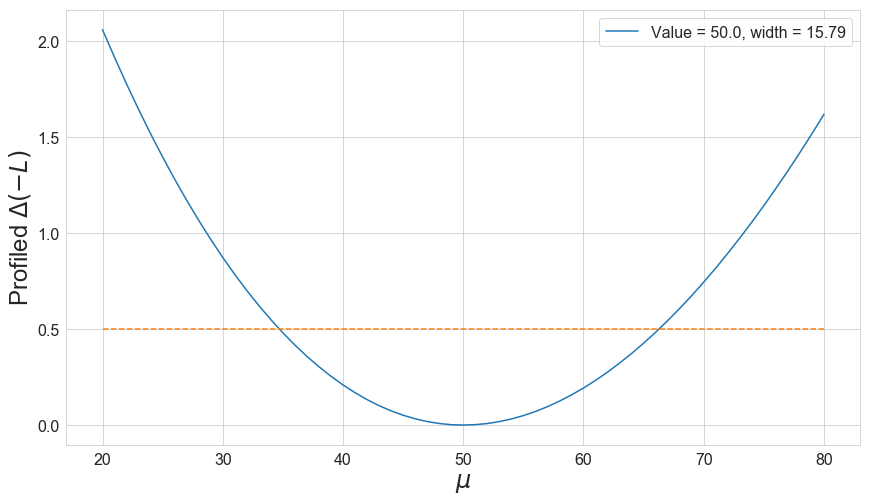

In [21]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [22]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [23]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [24]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0,1.0,0,0,0,0,0,0,0,0,0,0,0
1,4,1.0,4,4,4,4,4,4,4,4,4,4,4
2,1,1.0,1,1,1,1,1,1,1,1,1,1,1
3,4,1.0,4,4,4,4,4,4,4,4,4,4,4
4,4,1.0,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999996,6,0.0,6,6,6,6,6,6,6,6,6,8,8
999997,9,0.0,9,9,9,9,9,9,9,9,9,9,9
999998,7,0.0,7,7,7,7,7,7,7,7,7,7,7


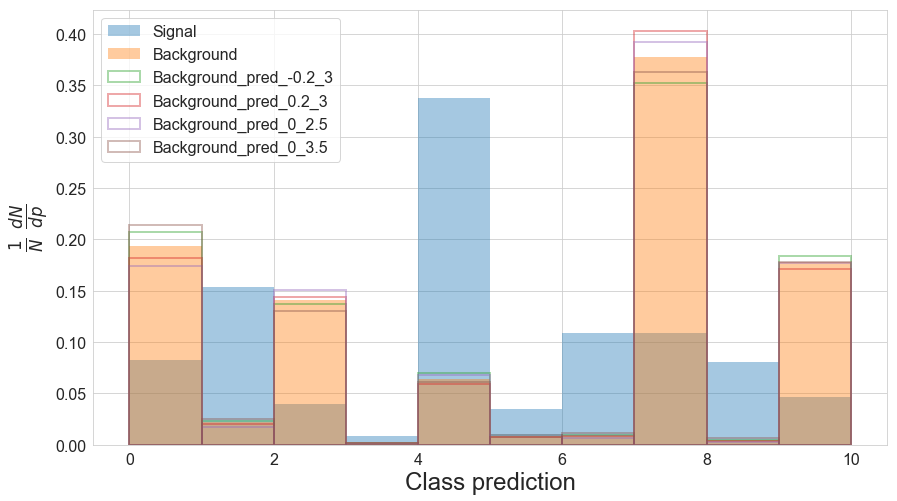

In [25]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.1877, 0.0187, 0.1474, 0.0015, 0.0730, 0.0106, 0.0078, 0.3673, 0.0032,
        0.1827])
tensor([0.2075, 0.0230, 0.1368, 0.0018, 0.0698, 0.0098, 0.0100, 0.3528, 0.0048,
        0.1837])
tensor([0.2273, 0.0267, 0.1270, 0.0020, 0.0666, 0.0091, 0.0123, 0.3378, 0.0067,
        0.1844])
tensor([0.1743, 0.0175, 0.1511, 0.0012, 0.0677, 0.0095, 0.0068, 0.3924, 0.0029,
        0.1766])
tensor([0.1941, 0.0218, 0.1405, 0.0015, 0.0645, 0.0086, 0.0090, 0.3778, 0.0045,
        0.1776])
tensor([0.2139, 0.0254, 0.1308, 0.0018, 0.0613, 0.0079, 0.0113, 0.3629, 0.0064,
        0.1784])
tensor([0.1619, 0.0160, 0.1542, 0.0010, 0.0620, 0.0085, 0.0059, 0.4179, 0.0025,
        0.1700])
tensor([0.1817, 0.0203, 0.1436, 0.0013, 0.0588, 0.0077, 0.0081, 0.4033, 0.0041,
        0.1711])
tensor([0.2015, 0.0239, 0.1338, 0.0016, 0.0556, 0.0070, 0.0104, 0.3883, 0.0060,
        0.1718])


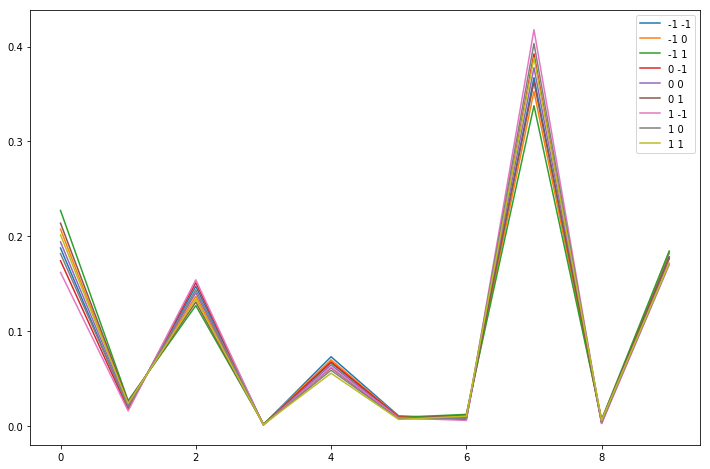

In [26]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [27]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [28]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [29]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [30]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [31]:
nll = to_np(nll)

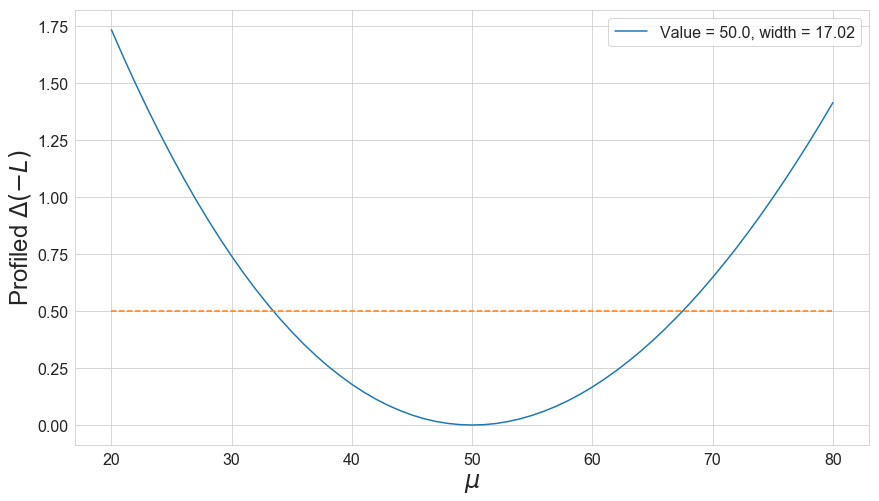

In [32]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [33]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [34]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [35]:
nll = to_np(nll)

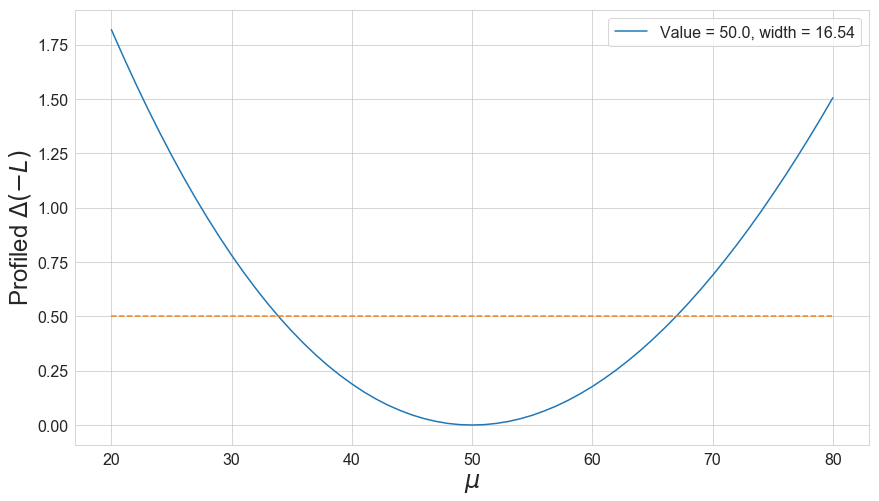

In [36]:
plot_likelihood(nll-nll.min())

## BM 2

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [38]:
nll = to_np(nll)

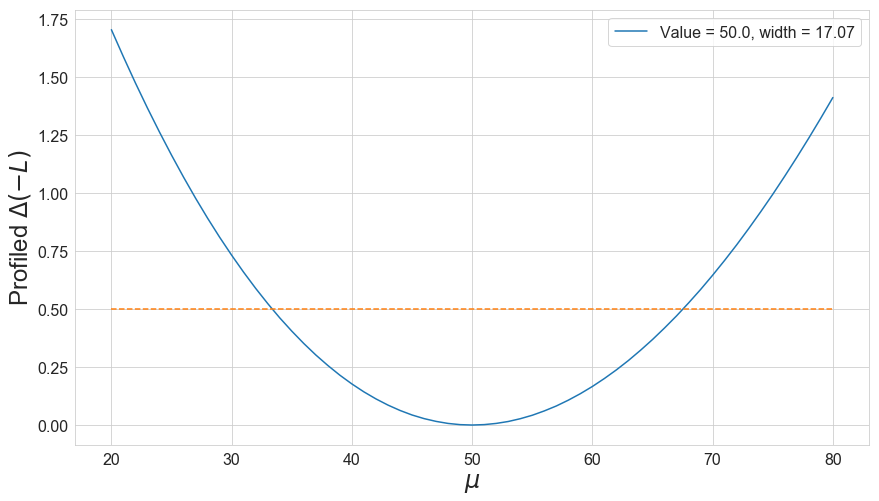

In [39]:
plot_likelihood(nll-nll.min())

## BM 3

In [40]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [41]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [42]:
nll = to_np(nll)

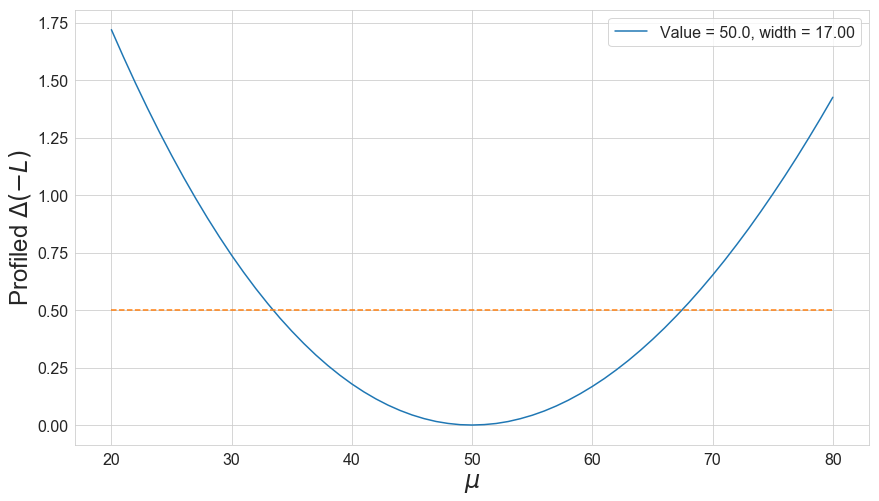

In [43]:
plot_likelihood(nll-nll.min())

## BM 4

In [44]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [45]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.2922,  0.1427, 25.4857])
Linear regime: Mu 21.0, alpha tensor([-0.2828,  0.1362, 24.5619])
Linear regime: Mu 22.0, alpha tensor([-0.2735,  0.1297, 23.6438])
Linear regime: Mu 23.0, alpha tensor([-0.2641,  0.1234, 22.7313])
Linear regime: Mu 24.0, alpha tensor([-0.2546,  0.1172, 21.8244])
Linear regime: Mu 25.0, alpha tensor([-0.2452,  0.1112, 20.9231])
Linear regime: Mu 26.0, alpha tensor([-0.2357,  0.1053, 20.0272])
Linear regime: Mu 27.0, alpha tensor([-0.2262,  0.0995, 19.1366])
Linear regime: Mu 28.0, alpha tensor([-0.2166,  0.0938, 18.2514])
Linear regime: Mu 29.0, alpha tensor([-0.2071,  0.0883, 17.3714])
Linear regime: Mu 30.0, alpha tensor([-0.1975,  0.0829, 16.4966])
Linear regime: Mu 31.0, alpha tensor([-0.1878,  0.0777, 15.6270])
Linear regime: Mu 32.0, alpha tensor([-0.1782,  0.0725, 14.7624])
Linear regime: Mu 33.0, alpha tensor([-0.1685,  0.0675, 13.9028])
Linear regime: Mu 34.0, alpha tensor([-0.1588,  0.0626, 13.0482])
Linear reg

In [46]:
nll = to_np(nll)

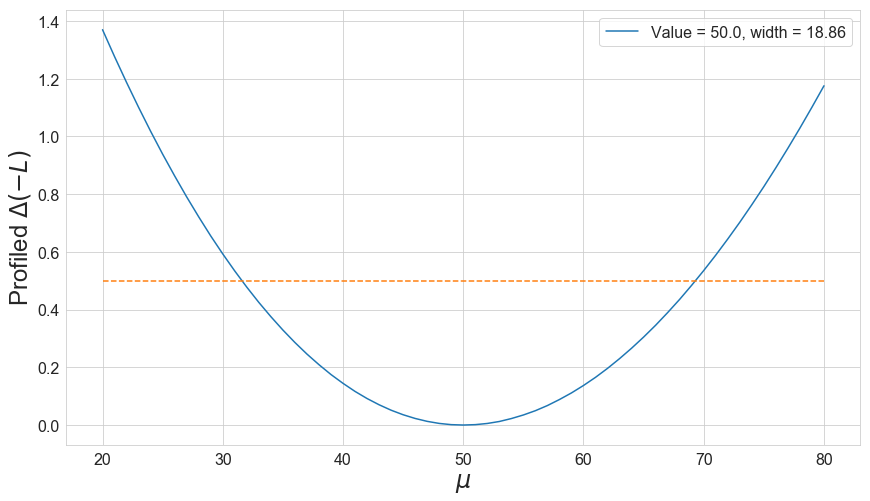

In [47]:
plot_likelihood(nll-nll.min())